# Basic MERA Manipulations & Optimization

`quimb` has preliminary support for the [MERA](https://arxiv.org/abs/quant-ph/0610099) class of states. Specifically, there is the {class}`~quimb.tensor.tensor_mera.MERA` class which constructs a {class}`~quimb.tensor.tensor_core.TensorNetwork` if supplied with isometries and unitaries.

{class}`~quimb.tensor.tensor_mera.MERA` inherits from {class}`~quimb.tensor.tensor_1d.TensorNetwork1DVector` and {class}`~quimb.tensor.tensor_1d.TensorNetwork1D` and so in fact shares many methods with {class}`~quimb.tensor.tensor_1d.MatrixProductState`.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

First we create the random MERA state (currently the number of sites ``n`` must be a power of 2):

In [2]:
n = 128
mera = qtn.MERA.rand_invar(n)

We also can set up some default drawing options, namely, to pin the physical (outer) indices in circle:

In [3]:
from math import cos, sin, pi

fix = {
    f'k{i}': (sin(2 * pi * i / n), cos(2 * pi * i / n))
    for i in range(n)
}

# reduce the 'spring constant' k as well
draw_opts = dict(fix=fix, k=0.01)

By default, the MERA constructor adds the ``'_ISO'`` and ``'_UNI'`` tensor tags to
demark the isometries and unitaries respectively:

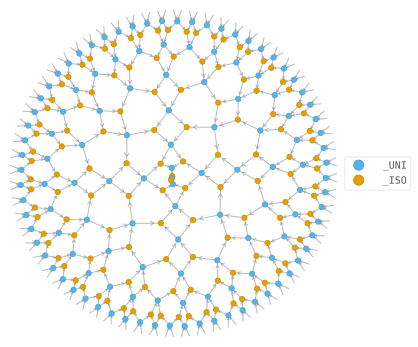

In [4]:
mera.draw(color=['_UNI', '_ISO'], **draw_opts)

It also tags each layer with ``'_LAYER2'`` etc.:

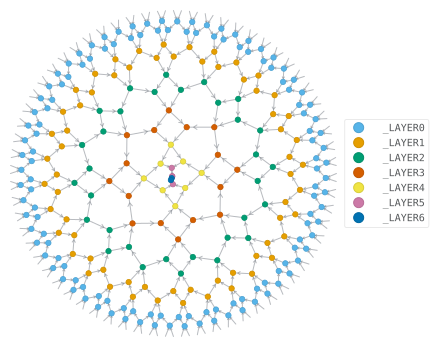

In [5]:
mera.draw(color=[f'_LAYER{i}' for i in range(7)], **draw_opts)

Finally, the site-tags of each initial tensor (``'I0'``, ``'I1'``, ``'I3'``, etc.) are propagated up through the isometries and unitaries, forming effective 'lightcones' for each site. Here, for example, we plot the lightcone of site 0, 40, and 80:

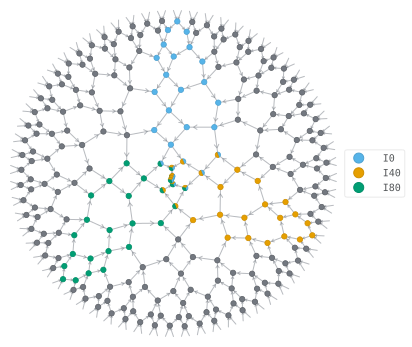

In [6]:
mera.draw(color=['I0', 'I40', 'I80'], **draw_opts)

Computing Local Quantities
----------------------------------------

In a MERA state, local quantities depend only on this lightcone. The way that ``quimb.tensor`` works supports this very naturally. Firstly, you can easily select all the tensors with site tag ``i``, i.e. the causal cone, with ``MERA.select(i)``:

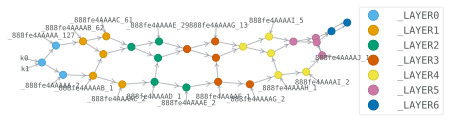

In [7]:
# select all tensors relevant for site-0
mera.select(0).draw(color=[f'_LAYER{i}' for i in range(7)])

Secondly, when combined with its conjugate network, all the dangling indices automatically match up. As an example, consider the state norm, but calculated for site 80 only:

In [8]:
nrm80 = mera.select(80).H  & mera.select(80)

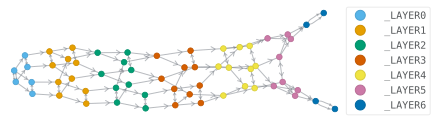

In [9]:
nrm80.draw(color=[f'_LAYER{i}' for i in range(7)])

We can contract this whole subnetwork efficiently to compute the actual value:

In [10]:
nrm80 ^ all

0.9999999999999938

As expected. Or consider we want to measure $\langle \psi | X_i Z_j | \psi \rangle$:

In [11]:
i, j = 50, 100
ij_tags = mera.site_tag(i), mera.site_tag(j)
ij_tags

('I50', 'I100')

Now we can select the subnetwork of tensors with *either* the site 50 or site 100 lightcone (and also conjugate to form $\langle \psi |$):

In [12]:
mera_ij_H = mera.select(ij_tags, which='any').H

For $X_i Z_j | \psi \rangle$ we'll first apply the X and Z operators. By default the gate operation propagates the site tags to the applied operators as well, or we could use ``contract=True`` to actively contract them into the MERA:

In [13]:
X = qu.pauli('X')
Z = qu.pauli('X')

XY_mera_ij = (
    mera
    .gate(X, i)
    .gate(Z, j)
    .select(ij_tags, which='any')
)

Now we can lazily form the tensor network of this expectation value:

In [14]:
exp_XZ_ij = (mera_ij_H & XY_mera_ij)

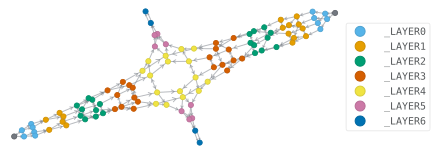

In [15]:
exp_XZ_ij.draw(color=[f'_LAYER{i}' for i in range(7)])

Which we can efficiently contract:

In [16]:
exp_XZ_ij ^ all

0.15883517895692317

In [17]:
%%timeit
exp_XZ_ij ^ all

2.14 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
# generate the 'bra' state
mera_H = mera.H.reindex_sites('b{}', range(20))

We again only need the tensors in the causal cones of these 20 sites:

In [19]:
# NB we have to slice *before* combining the subnetworks here.
#    this is because paired indices are mangled when joining
#    two networks -> only dangling indices are guranteed to 
#    retain their value
rho = (
    mera_H.select(slice(20), which='any') & 
    mera.select(slice(20), which='any')
)

We can see what this density operator looks like as a tensor network:

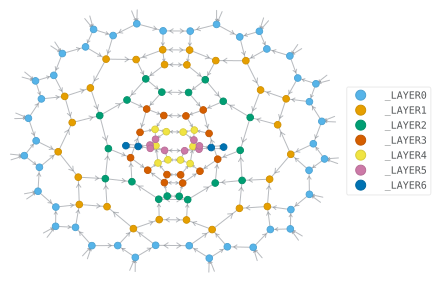

In [20]:
rho.draw(color=[f'_LAYER{i}' for i in range(7)])

Or we can plot the sites (note how higher and higher tensors have more and more site tags):

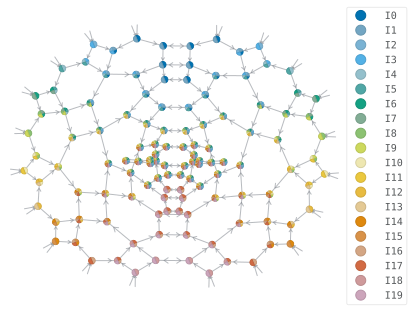

In [21]:
rho.draw(color=[f'I{i}' for i in range(20)])

This density matrix is too big to explicitly form (it would need $2^{40}$, about a trillion, elements).
On the other hand we can treat it as linear operator, in which case we only need to compute its action on
a vector of size $2^{20}$. This allows the computation of 'spectral' quantities of the form $\text{Tr}(f(\rho))$.

One such quantity is the entropy $-\text{Tr} \left( \rho \log_2 \rho \right) $:

In [22]:
# mark the indices as belonging to either the 'left' or 
#     'right' hand side of the effective operator
left_ix = [f'k{i}' for i in range(20)]
rght_ix = [f'b{i}' for i in range(20)]

# form the linear operator
rho_ab = rho.aslinearoperator(left_ix, rght_ix, backend='torch')
rho_ab

<1048576x1048576 TNLinearOperator with dtype=float64>

In [23]:
f = qu.xlogx
S =  - qu.approx_spectral_function(rho_ab, f, tol=0.02)
print("rho_entropy ~", S)

rho_entropy ~ 5.454770371829187


To compute a genuine entanglement measure we need a further small trick. Specifically, if we are computing the negativity between subsystem A and subsystem B, we can perform the [partial transpose](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion) simply by swapping subsystem B's 'left' indices for right indices. This creates a linear operator of $\rho_{AB}^{T_B}$, which we can compute the logarithmic negativity for, 
$\mathcal{E} = \log_2 \text{Tr} |\rho_{AB}^{T_B}|$:

In [24]:
# partition 20 spins in two
sysa = range(0, 10)
sysb = range(10, 20)

# k0, k1, k2, ... b10, b11, b12, ...
left_ix = [f'k{i}' for i in sysa] + [f'b{i}' for i in sysb]
# b0, b1, b2, ... k10, k11, k12, ...
rght_ix = [f'b{i}' for i in sysa] + [f'k{i}' for i in sysb]

rho_ab_pt = rho.aslinearoperator(left_ix, rght_ix, backend='torch')

Now we just to to take ``abs`` as the function $f$ and scale the result with $\log_2$:

In [25]:
f = abs
neg = qu.approx_spectral_function(rho_ab_pt, f, tol=0.02)
print("rho_ab logarithmic negativity ~", qu.log2(neg))

rho_ab logarithmic negativity ~ 1.5515528003023578


In [26]:
# total length (currently must be power of 2)
L = 2**6

# max bond dimension
D = 8

# use single precision for quick GPU optimization
dtype = 'float32'

mera = qtn.MERA.rand(L, max_bond=D, dtype=dtype)

# this is the function that projects all tensors 
# with ``left_inds`` into unitary / isometric form
mera.unitize_()

<MERA(tensors=126, indices=252, L=64, max_bond=8)>

Then the dictionary of local terms describing the Hamiltonian:

In [27]:
H2 = qu.ham_heis(2).real.astype(dtype)
terms = {(i, (i + 1) % L): H2 for i in range(L)}

For which we can compute the exact energy:

In [28]:
if L <= 20:
    # numerical result
    en = qu.groundenergy(qu.ham_heis(L, cyclic=True, sparse=True))
else:
    # analytic result for long (PBC) chains
    en = qu.heisenberg_energy(L)
    
en

-28.374337597812207

Then we need two functions to supply to the optimizer:

* ``norm_fn``, which projects the TN into the constrained form (i.e. isometric)

In [29]:
def norm_fn(mera):
    # there are a few methods to do the projection
    # exp works well for optimization
    return mera.unitize(method='exp')

* ``loss_fn``, which takes the projected TN and computes the scalar to minimize

In [30]:
def local_expectation(mera, terms, where, optimize='auto-hq'):
    """Compute the energy for a single local term.
    """
    # get the lightcone for `where`
    tags = [mera.site_tag(coo) for coo in where]
    mera_ij = mera.select(tags, 'any')
    
    # apply the local gate
    G = terms[where]
    mera_ij_G = mera_ij.gate(terms[where], where)
    
    # compute the overlap - this is where the real computation happens
    mera_ij_ex = (mera_ij_G & mera_ij.H)
    return mera_ij_ex.contract(all, optimize=optimize)


def loss_fn(mera, terms, **kwargs):
    """Compute the total energy as a sum of all terms.
    """
    return sum(
        local_expectation(mera, terms, where, **kwargs)
        for where in terms
    )

To find a high quality contraction path for each term we'll also instantiate a ``cotengra`` optimizer:

In [31]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    progbar=True,
    reconf_opts={},
    max_repeats=16,
    # directory=  # set this for persistent cache
)

The first time each contraction is encountered it will be optimized, after with 
the path will be saved for matching contractions:

In [32]:
loss_fn(norm_fn(mera), terms, optimize=opt)

log2[SIZE]: 19.00 log10[FLOPs]: 9.01: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]


-0.021592675417196006

These sizes and FLOPS are all very manageable. And a second call should be
much faster:

In [33]:
%%time
loss_fn(norm_fn(mera), terms, optimize=opt)

CPU times: user 5.06 s, sys: 39.5 ms, total: 5.1 s
Wall time: 662 ms


-0.021592675417196006

Now we are ready to set-up our optimizer object:

In [34]:
tnopt = qtn.TNOptimizer(
    mera,
    loss_fn=loss_fn, 
    norm_fn=norm_fn,
    loss_constants={'terms': terms},
    loss_kwargs={'optimize': opt},
    autodiff_backend='torch', device='cuda', jit_fn=True, 
)

Since we set ``jit_fn=True``, the first step involves compiling the computation,
which might take some time and print some (ignorable) warnings:

In [35]:
%%time
tnopt.optimize(1)

  0%|          | 0/1 [00:00<?, ?it/s]/media/johnnie/Storage2TB/Sync/dev/python/quimb/quimb/tensor/array_ops.py:94: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  d = max(m, n)
/media/johnnie/Storage2TB/Sync/dev/python/quimb/quimb/tensor/array_ops.py:97: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return expx[:m, :n]
/media/johnnie/Storage2TB/Sync/dev/python/quimb/quimb/tensor/tensor_core.py:1706: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value wil

CPU times: user 13.1 s, sys: 2.08 s, total: 15.2 s
Wall time: 11.4 s


<MERA(tensors=126, indices=252, L=64, max_bond=8)>

At this point every iteration should be very fast:

In [36]:
tnopt.optimizer = 'l-bfgs-b'  # the default
mera_opt = tnopt.optimize(999)

-28.175458908081055: 100%|██████████| 999/999 [05:34<00:00,  2.99it/s]


In [37]:
tnopt.optimizer = 'adam'  # useful for final iterations
mera_opt = tnopt.optimize(1000)

-28.269123077392578: 100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


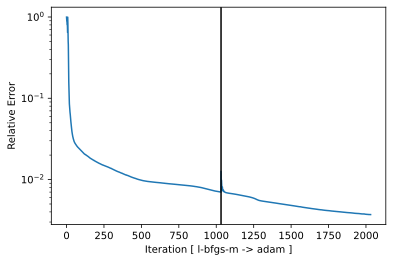

In [38]:
import matplotlib.pyplot as plt
import numpy as np

rel_err = (np.array(tnopt.losses) - en) / abs(en)

plt.plot(rel_err)
plt.xlabel('Iteration [ l-bfgs-m -> adam ]')
plt.ylabel('Relative Error')
plt.yscale('log')
plt.axvline(len(tnopt.losses) - 1000, color='black')